# Animal Faces Classification

In [1]:
# !kaggle datasets download -d andrewmvd/animal-faces
# !unzip animal-faces.zip

## Import Libs

In [2]:

import torch
from torch import nn # for building the models arch. 
from torch.optim import Adam # optimizer for training the model
import torchvision.transforms as transforms # for the data augmentation and preprocessing
from torch.utils.data import Dataset, DataLoader # for creating custom datasets and loading data in batches
from torchinfo import summary
from sklearn.preprocessing import LabelEncoder # for encoding the labels of the dataset
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torchvision.transforms import functional as F


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cpu


## Reading Images

## 

In [3]:
image_path = []
labels = []

# Reading each image and its corresponding label from the dataset
for i in os.listdir("data/animal-faces"):
    # print("\nProcessing folder: ", i)
    for label in os.listdir(f"data/animal-faces/{i}"):
        # print("Label: ", label)
        for image in os.listdir(f"data/animal-faces/{i}/{label}"):
            # print("Image: ", image)
            image_path.append(f"data/animal-faces/{i}/{label}/{image}")
            labels.append(label)

# Creating dataframe to store the image paths and their corresponding labels
df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(df["labels"].unique())
print(df.head())
print(df.tail())

<StringArray>
['cat', 'dog', 'wild']
Length: 3, dtype: str
                                          image_path labels
0  data/animal-faces/train/cat/pixabay_cat_000455...    cat
1  data/animal-faces/train/cat/pixabay_cat_001993...    cat
2  data/animal-faces/train/cat/pixabay_cat_004633...    cat
3  data/animal-faces/train/cat/pixabay_cat_002242...    cat
4  data/animal-faces/train/cat/pixabay_cat_002524...    cat
                                              image_path labels
16125  data/animal-faces/val/wild/flickr_wild_003335.jpg   wild
16126  data/animal-faces/val/wild/flickr_wild_002942.jpg   wild
16127  data/animal-faces/val/wild/flickr_wild_000833.jpg   wild
16128  data/animal-faces/val/wild/flickr_wild_002956.jpg   wild
16129  data/animal-faces/val/wild/flickr_wild_003137.jpg   wild


## Preprocessing

In [14]:
train = df.sample(frac=0.7) # 70% of the data for training
test = df.drop(train.index) # remaining 30% for testing
val = test.sample(frac=0.5) # 15% of the data of test for validation
test = test.drop(val.index) # Remaining 15% for testing

print("Train set size: ", len(train))
print("Test set size: ", len(test))
print("Validation set size: ", len(val))

# Label encoding the labels of the dataset
label_encoder = LabelEncoder()
label_encoder.fit(df["labels"]) # fitting the label encoder on the labels of the dataset

# Makes all the images have the same properties (size, normalization, etc.) before feeding them into the model.
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])


Train set size:  11291
Test set size:  2419
Validation set size:  2420


## Custom Image Dataset

In [15]:
class AnimalFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(df['labels']).astype(int), dtype=torch.long) # encoding the labels of the dataset from string to integer
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx,0] # getting the image path from the dataframe
        labels = self.labels[idx] # getting the label from the encoded labels (integers)
        
        image = Image.open(img_path).convert("RGB") # opening the image and converting it to RGB
        
        # # Convert PIL Image to Tensor Manually
        # image = F.to_tensor(image)  # Converts PIL -> tensor, CHW, float [0,1]
        
        if self.transform:
            image = self.transform(image) # applying the transformations to the image
            
        return image, labels

In [16]:
train_dataset = AnimalFaceDataset(df = train, transform=transform)
print(len(train_dataset))
valid_dataset = AnimalFaceDataset(df = val, transform=transform)
test_dataset = AnimalFaceDataset(df=test, transform=transform)

11291


## Display Random Image

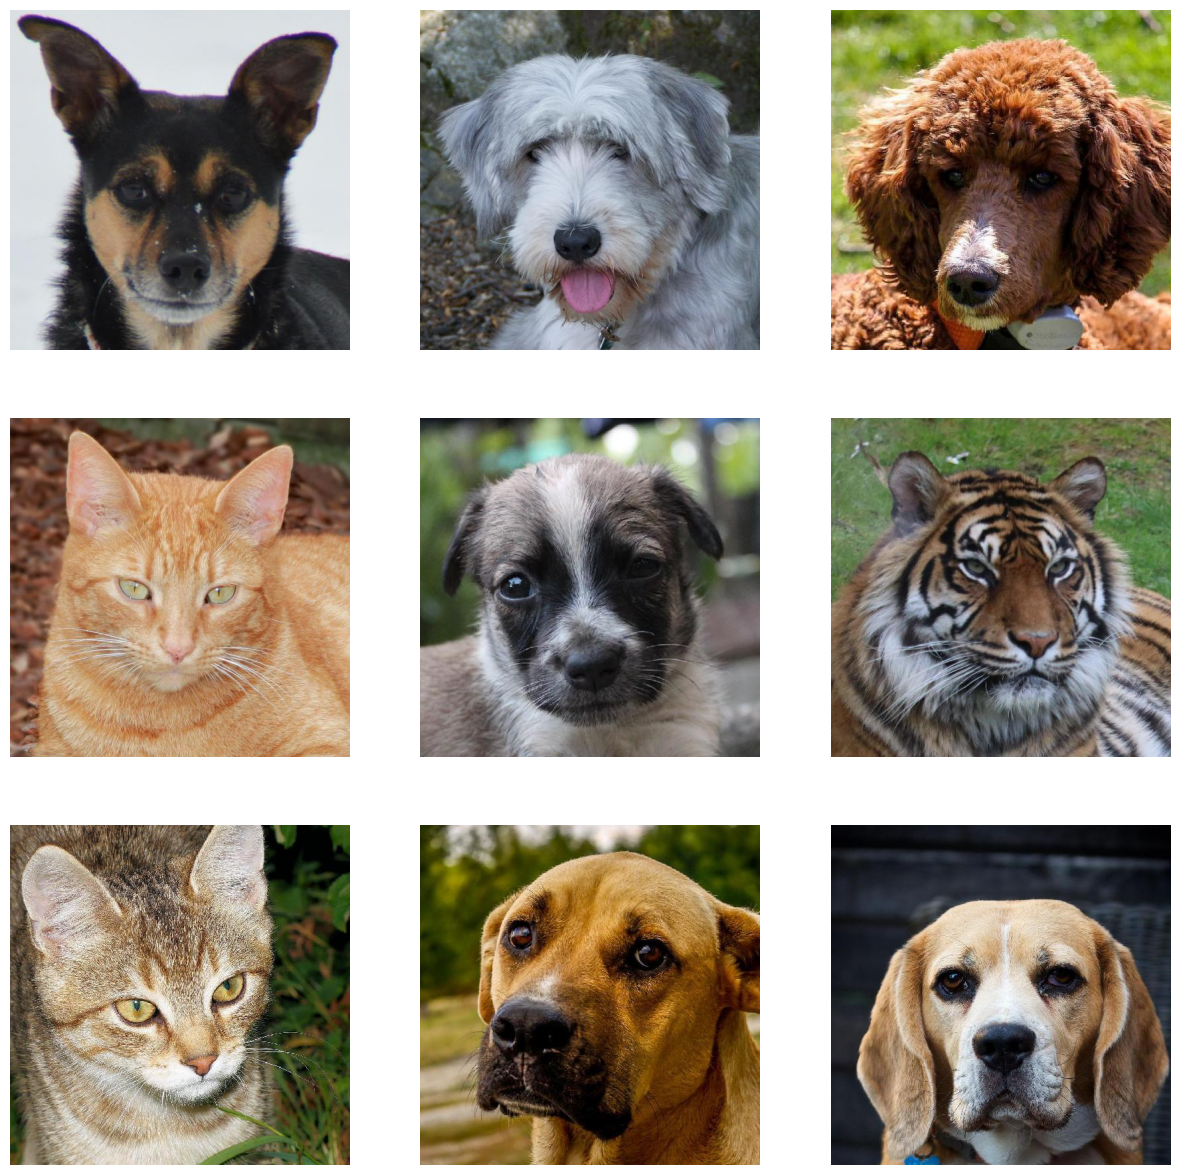

In [17]:
n_row = 3
n_col = 3

fig, ax = plt.subplots(n_row, n_col, figsize = (15,15))

# Display random images from df. We will be converting the int to RGB
for row in range(n_row):
    for col in range(n_col):
        image = Image.open(df.sample(n=1).iloc[0]["image_path"]).convert("RGB")
        
        ax[row, col].imshow(image)
        ax[row,col].axis("off")

plt.show()

## Feature Engineering

In [18]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10
LEN_CLASS = len(df['labels'].unique())
print("Number of classes: ", LEN_CLASS)

# Creating Data Loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=False)

Number of classes:  3


### Create Network

In [19]:
class AnimalFaceClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Just declaring the layers of the models
        self.conv1 = nn.Conv2d(3,32, kernel_size=3, padding=1) # 3 input channels (RGB) Grayscale is 1 input channel, 32 output channels, kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 32 input channels (from the previous conv layer), 64 output channels, kernel size of 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 64 input, 128 output, kernel size of 3
        
        self.pooling = nn.MaxPool2d(2,2) # pooling layer with kernel size of 2 and stride of 2
        
        self.relu = nn.ReLU() # Activation Function
        
        self.flatten = nn.Flatten() # flattening the output of the convolutional layers to feed it into the fully connected layers
        self.linear = nn.Linear(128*16*16, 128)# fully connected layer with 128 input features (from the previous conv layer) and 128 output features
        
        self.output = nn.Linear(128, LEN_CLASS) # output layer with 128 input features and number of output features equal to the number of unique labels in the dataset
        
    def forward(self, x):
        x = self.conv1(x) # applying the first convolutional layer (32,128,128) -> output(32), image size (128,128)
        x = self.pooling(x) # Reduces size of the features (32, 64,64)
        x = self.relu(x) # Changes the values inside the metrics 
        
        x = self.conv2(x) # (64, 64,64) -> output(64), image size (64,64)
        x = self.pooling(x) # (64, 32,32)
        x = self.relu(x)
        
        x = self.conv3(x) # (128, 32, 32)
        x = self.pooling(x) # (128, 16,16)
        x = self.relu(x)
        
        x = self.flatten(x) # flattens output to feed into FC layer (128*16*16)
        x = self.linear(x) # (128*16*16, 128)
        x = self.output(x) # (128, LEN_CLASS)
        
        return x

In [20]:
model = AnimalFaceClassifier().to(device)
summary(model, input_size= (1,3,128,128))

Layer (type:depth-idx)                   Output Shape              Param #
AnimalFaceClassifier                     [1, 3]                    --
├─Conv2d: 1-1                            [1, 32, 128, 128]         896
├─MaxPool2d: 1-2                         [1, 32, 64, 64]           --
├─ReLU: 1-3                              [1, 32, 64, 64]           --
├─Conv2d: 1-4                            [1, 64, 64, 64]           18,496
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─ReLU: 1-6                              [1, 64, 32, 32]           --
├─Conv2d: 1-7                            [1, 128, 32, 32]          73,856
├─MaxPool2d: 1-8                         [1, 128, 16, 16]          --
├─ReLU: 1-9                              [1, 128, 16, 16]          --
├─Flatten: 1-10                          [1, 32768]                --
├─Linear: 1-11                           [1, 128]                  4,194,432
├─Linear: 1-12                           [1, 3]                    38

In [21]:
criterion = nn.CrossEntropyLoss() # loss function for multi-class classification
optimizer = Adam(model.parameters(), lr=LR) # optimizer for training the model

## Training Loop

In [22]:
train_loss_train_plot = []
train_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_valid = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        break
    break